## Import Libraries and Data

In [1]:
import PipettingMassBalance as pmb
import pandas as pd
%matplotlib notebook

speciesList = pmb.PipettingSpecies.readCSV('SpeciesDictionary.csv')
instructions = pmb.PipettingInstructions.readCSV('DoE_csv/MasterDataset_OT_DoE_17-27-07-2023.csv', firstRow=648, lastRow=654)
targetVolume = 10
sampleList = pmb.PipettingSample.createSamples(instructions,targetVol=targetVolume)
maxVolume = 1
for sample in sampleList:
    sample.getTotalDensity(speciesDictionary=speciesList)
    sample.getVolFracSeries(speciesDictionary=speciesList)
steps = pmb.PipettingStep.createSteps(instructions=instructions,speciesDictionary=speciesList,sampleList=sampleList,maxVol=maxVolume)

massProfile = pmb.MassProfile('mass_data/MassProfile_170723_S649-654.csv',t_baseline=25,derivNoise=0.005,secDerivNoise=0.001)
#default t_baseline=25

## Analyse Water Addition

In [2]:
(water_mass,t1)=massProfile.analyseWater(avg_window=10,bl_mult=5)
water=pmb.PipettingSpecies.getSpecies(speciesList, 'water')
water_volume_act=water.getVolume(water_mass)
water_volume_set=0
for sample in sampleList:
    water_volume = sample.waterVol
    water_volume_set = water_volume_set + water_volume
    sample.actualMass = water_volume/water.density
print("This equals a volume of " + str(round(water_volume_act,3)) + "m; expected was "\
      + str(round(water_volume_set,3)) + "mL; error is " + str(round(abs((water_volume_set-water_volume_act)/water_volume_set)*100,3)) + "%")

Water Transfer started at t=54s and ended at t=482s; mass=44.3107g
This equals a volume of 44.399m; expected was 44.358mL; error is 0.093%


## Analyse Surfactants

Peak threshold for 1st derivative = 0.001 g/s and for 2nd derivative = 0.0003125 g/s^2


<IPython.core.display.Javascript object>


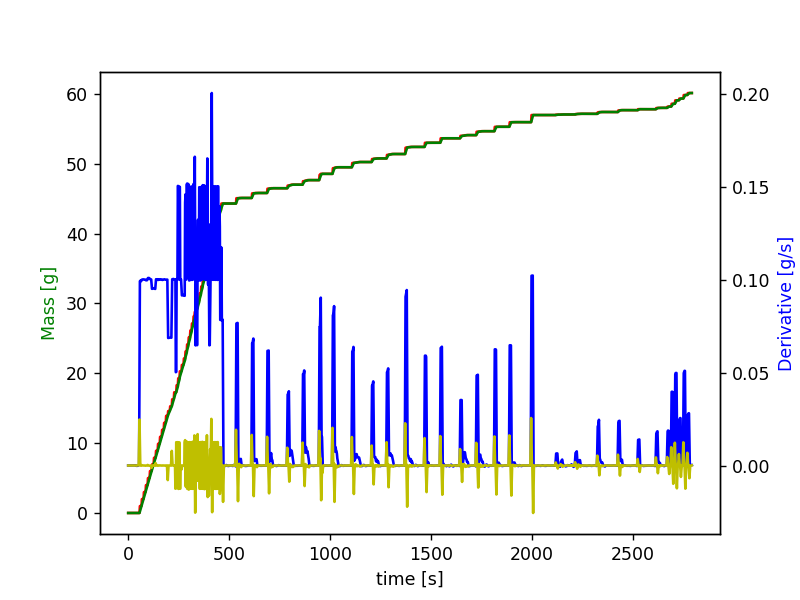

Addition of 0.798g Plantapon ACG 50 detected from 530s to 566s - expected volume = 0.768mL and actual volume = 0.705mL (resulting error is 8.159%)
Addition of 0.717g Plantapon ACG 50 detected from 608s to 644s - expected volume = 0.574mL and actual volume = 0.635mL (resulting error is 10.617%)
Addition of 0.684g Plantapon ACG 50 detected from 684s to 722s - expected volume = 0.574mL and actual volume = 0.607mL (resulting error is 5.586%)
Addition of 0.515g Plantapon LC 7 detected from 784s to 824s - expected volume = 0.59mL and actual volume = 0.487mL (resulting error is 17.566%)
Addition of 0.652g Plantapon LC 7 detected from 860s to 902s - expected volume = 0.59mL and actual volume = 0.616mL (resulting error is 4.42%)
Addition of 0.9g Plantapon LC 7 detected from 942s to 968s - expected volume = 0.924mL and actual volume = 0.855mL (resulting error is 7.387%)
Addition of 0.946g Plantapon LC 7 detected from 1008s to 1046s - expected volume = 0.896mL and actual volume = 0.896mL (resulti

In [3]:
# default: bl_mult=5, mergeSens=10
t2 = massProfile.analyseIngredients(avg_window=5, bl_mult=5, mergeSens=10, specType='surfactant', steps=steps,start_idx=t1,show=True)

#t2 = massProfile.defineIngredientsManually(specType='surfactant',steps=steps,show=True,manualTimes=[560,600,700,800,900,1000,1100,1150,1250,1320,1400,1500,1580,1650,1730,1830,1920,2000,2080,2140])

## Analyse Polyelectrolytes

Peak threshold for 1st derivative = 0.0015625 g/s and for 2nd derivative = 0.000390625 g/s^2


<IPython.core.display.Javascript object>


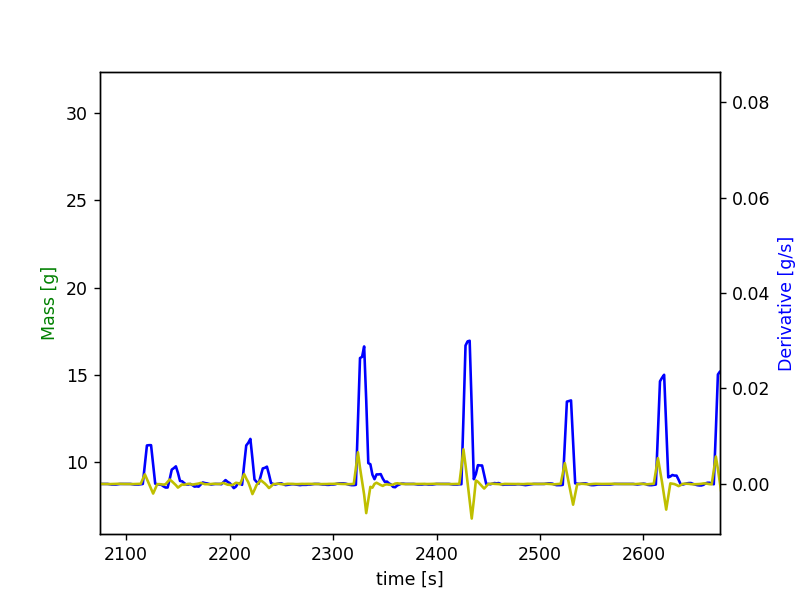

Addition of 0.064g Salcare Super 7 detected from 2114s to 2132s - expected volume = 0.104mL and actual volume = 0.058mL (resulting error is 44.13%)
Addition of 0.025g Salcare Super 7 detected from 2138s to 2156s - expected volume = 0.09mL and actual volume = 0.023mL (resulting error is 74.625%)
Addition of 0.102g Salcare Super 7 detected from 2210s to 2244s - expected volume = 0.258mL and actual volume = 0.092mL (resulting error is 64.379%)
Addition of 0.263g Salcare Super 7 detected from 2320s to 2352s - expected volume = 0.245mL and actual volume = 0.239mL (resulting error is 2.323%)
Addition of 0.271g Salcare Super 7 detected from 2422s to 2452s - expected volume = 0.093mL and actual volume = 0.245mL (resulting error is 165.196%)
Addition of 0.138g Salcare Super 7 detected from 2520s to 2538s - expected volume = 0.166mL and actual volume = 0.125mL (resulting error is 25.0%)


In [4]:
# default bl_mult = 5, default mergeSens = 5
t3 = massProfile.analyseIngredients(avg_window=4, bl_mult=5, mergeSens=5, specType='polyelectrolyte',steps=steps,start_idx=t2,show=True)

#t3 = massProfile.defineIngredientsManually(specType='polyelectrolyte',steps=steps,show=True,manualTimes=[2014,2112,2210,2314,2412,2494,2564])

## Analyse Thickeners

In [ ]:
# default bl_mult = 1, default mergeSens = 1
t4 = massProfile.analyseIngredients(avg_window=1, bl_mult=1, mergeSens=1, specType='thickener',steps=steps,start_idx=t3,show=True)

#t4 = massProfile.defineIngredientsManually(specType='thickener',steps=steps,show=True,manualTimes=[2600,2616,2636,2656,2676,2884,2906])

## Consolidate results and create output

In [ ]:
for step in steps:
    step.addToSample()
actualMassFractions = pd.DataFrame(dtype='float64').reindex_like(instructions)
actualMassFractions[:]=0
for i in range(len(sampleList)):
    actualMassFractions['ID'].iloc[i] = sampleList[i].sampleId
    for entry in sampleList[i].addedMassSeries.iteritems():
        actualMassFractions[entry[0]].iloc[i] = entry[1]/sampleList[i].actualMass*100
actualMassFractions.to_csv('mass_data/FreshlyAnalysed_170723_S643-S648.csv', index=False)
actualMassFractions